In [1]:
from importlib import reload # to reload modules
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import matplotlib.colors as colors
import mpl_scatter_density
import pandas as pd # Pandas
# import uproot
import pickle
import logging
import pprint

import os # read directories etc.
from scipy.optimize import curve_fit
from scipy.stats import chisquare, goodness_of_fit, skew, skewtest

import pylandau  # Landau Gaussian convolution

import LoadBatch
reload(LoadBatch)
from LoadBatch import *

from SensorClasses import *

verbose = False


In [2]:
### set logs level
logging.basicConfig(level=logging.WARNING, format='[%(levelname)s] -\t %(message)s')

In [3]:
PIXEL_SIZE = 0.0185 #mm

### choose the bins so that they match the MIMOSA pixels (which are just the coordinates)
large_bins = (np.arange(0, 900,1),
              np.arange(0, 600,1))

bins1 = (np.arange(450, 700, 1),
        np.arange(100, 500, 1))

bins2 = (np.arange(350, 700, 1),
              np.arange(150, 500, 1))

bins3 = (np.arange(300, 800, 1),
              np.arange(0, 450, 1))

bins4 = (np.arange(500, 800, 1),
              np.arange(100, 500, 1))

bins5 = (np.arange(450, 800, 1),
              np.arange(100, 500, 1))

### Load the dictionary of sensor names and runs
dict_of_batches = read_pickle("dict_of_batches.pickle")

logging.info(f"dictionary of the batches: \n{dict_of_batches}")

### presentation path
pres_path = '/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/various plots/edge_studies/'

In [4]:
SAVE = False

this_batch = 401


colormap = ['k','b','g','r']
threshold_charge = 4 #fC
transimpedance = 4700

S = "S1"
DUTs = [1,2,3]
print("Batch: ", this_batch)
print(S)
df = load_batch(this_batch,S)
print(f'MCP: {dict_of_batches[this_batch].S[S].channels["Ch1"].voltage} V, angle: {dict_of_batches[this_batch].angle}°', 'temperature:%.2f°C'%dict_of_batches[this_batch].temperature)

these_bins = bins1
time_bins = 5000
use_for_geometry_cut = 'pulseheight'

### show all informations about each sensor
temp_dict = {}
for ch, sensor in dict_of_batches[this_batch].S[S].channels.items():
#     print(f"{S}, {ch}:", sensor.__dict__)
    temp_dict[(S,ch)] = sensor.__dict__
temp_df = pd.DataFrame(temp_dict)

display(temp_df)

Batch:  401
S1
MCP: 2500 V, angle: 0.0° temperature:-30.56°C


S1                                                      
                     Ch1               Ch2               Ch3               Ch4
name                 MCP  USTC2.1-W17-P6-A  USTC2.1-W17-P6-A  IMEv3-W12-C3-1-4
board           no_board            CERN-3            CERN-3            CERN-1
dut_position         5.0               3.0               3.0                 1
fluence                0                 0                 0                 0
transimpedance        -1              4700              4700              4700
voltage             2500               -80               -80               -80

DUT_1
DUT_2
DUT_3


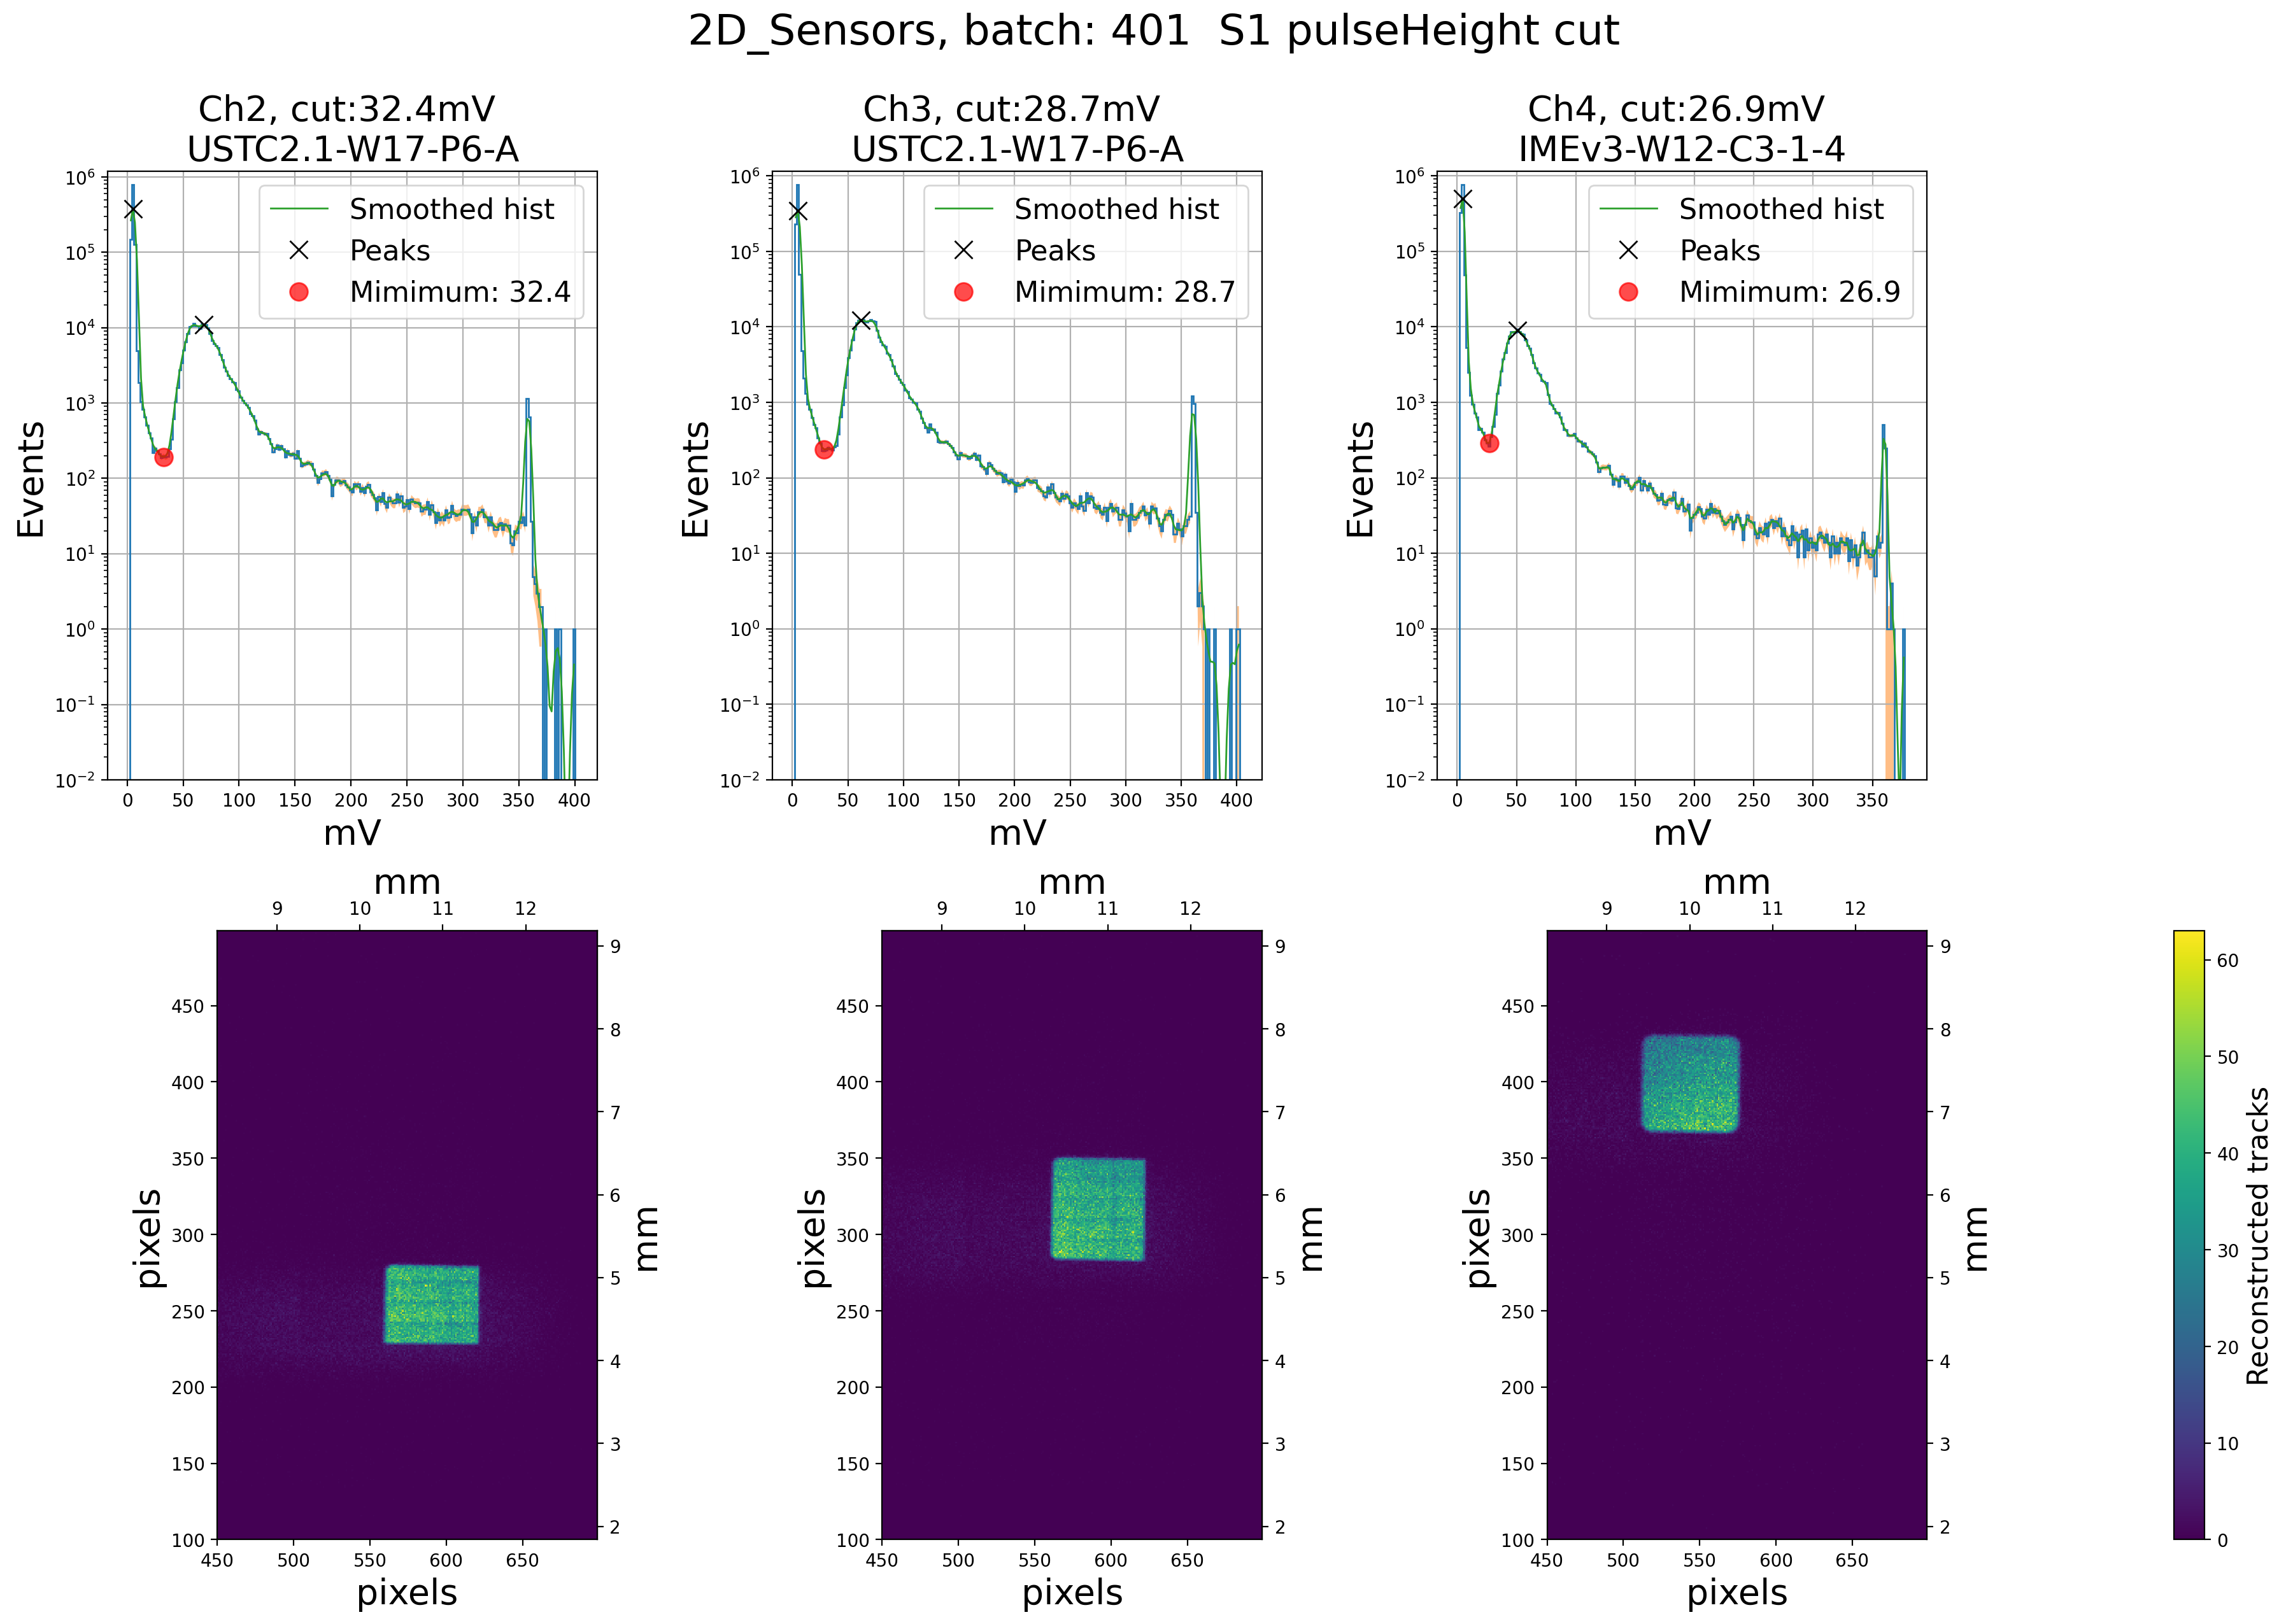

In [5]:
fig, axes = plot(df, "2D_Sensors", dict_of_batches[this_batch], S, bins=these_bins, n_DUT=[1,2,3], 
     savefig=SAVE, savefig_details=f' {S} pulseHeight cut', savefig_path=pres_path, fmt='png')

# fig, axes = plot(df, "2D_Sensors", dict_of_batches[this_batch], S, bins=these_bins, n_DUT=[2], 
#      savefig=SAVE, savefig_details=f' {S} pulseHeight cut', savefig_path=pres_path, fmt='png', fig_ax=(fig,axes))

# Plotting two channels together
Plot Ch4 of S1 and Ch4 of S2 (batch 401)
I should write a list of all the batches suitable to be compared

(250.0, 300.0)

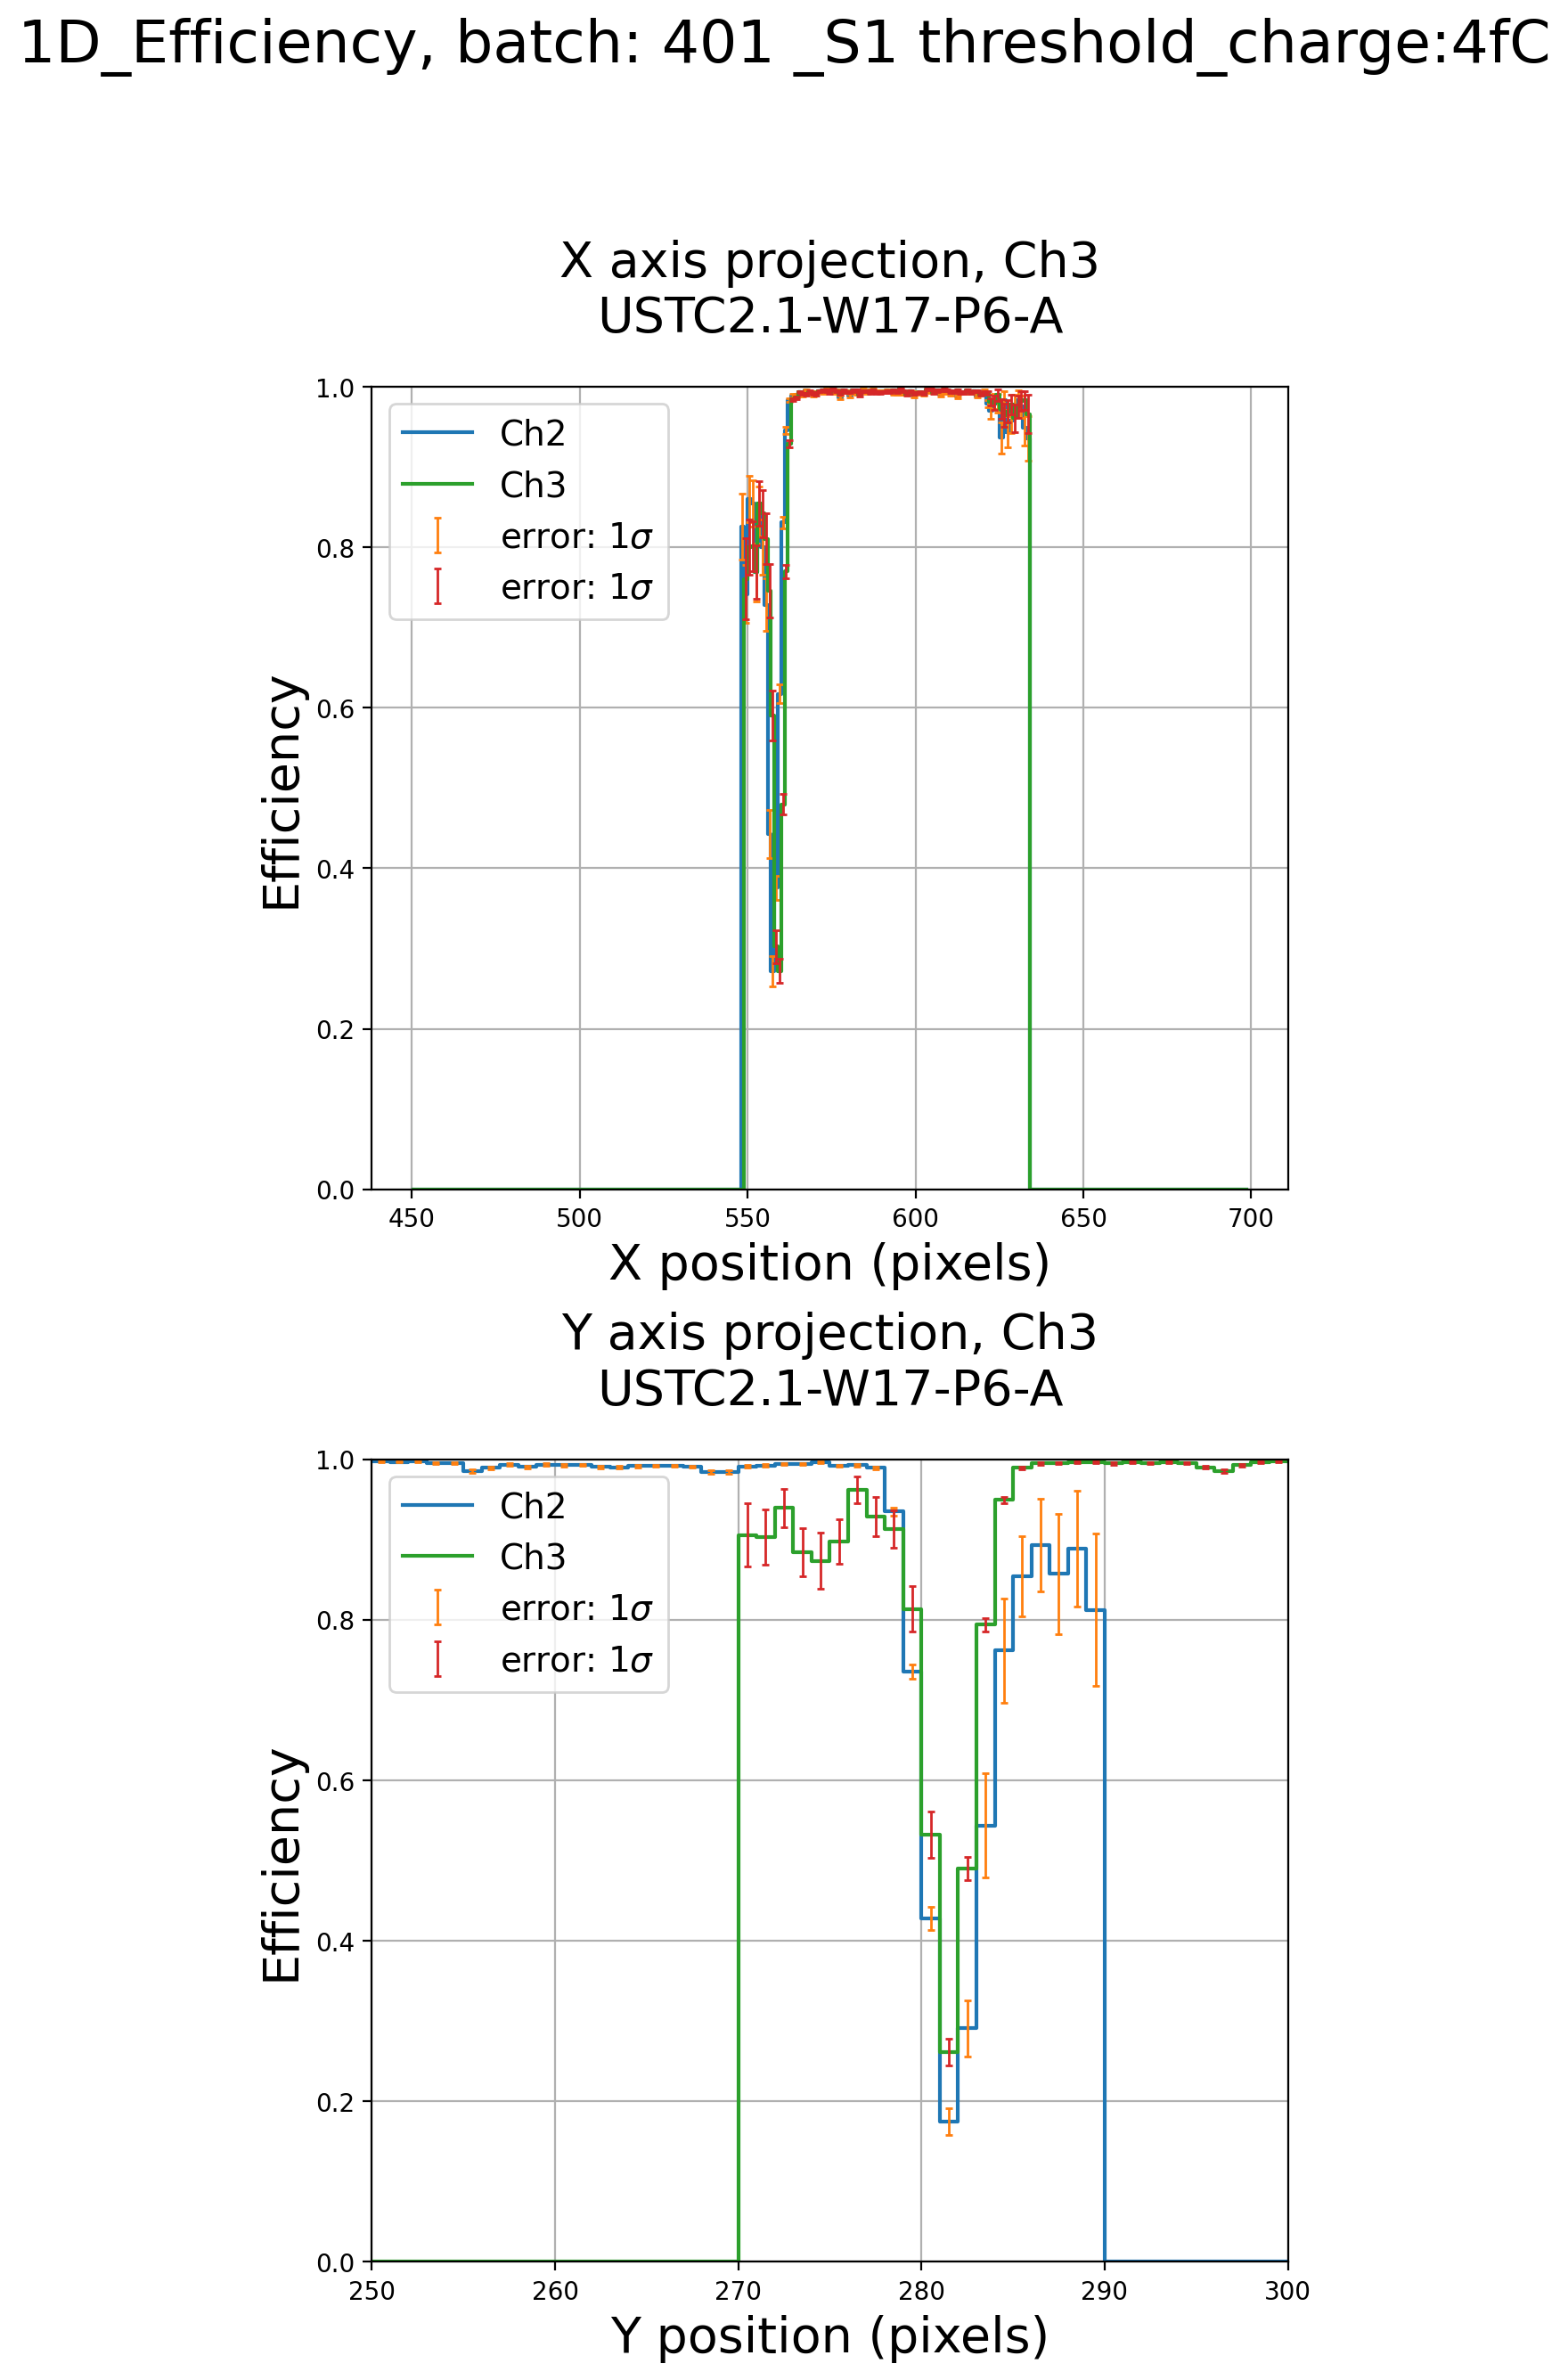

In [6]:
S = 'S1'
dut = 1
df = load_batch(this_batch,S)
time_cut = time_mask(df, DUT_number=dut, sigmas=3)[0]

fig, axes = plot(df, "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut='XY', mask=3*[time_cut],
                 bins=these_bins, n_DUT=[dut], efficiency_lim=(0,1), extra_info=False, savefig=SAVE, savefig_details=f'_{S} threshold_charge:{threshold_charge}fC')


S = 'S1' #'S2'
dut = 2
# df = load_batch(this_batch,S)
time_cut = time_mask(df, DUT_number=dut, sigmas=3)[0]

fig, axes = plot(df, "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut='XY', mask=3*[time_cut],
                 bins=these_bins, n_DUT=[dut], efficiency_lim=(0,1), savefig=SAVE, extra_info=False, savefig_details=f'_{S} threshold_charge:{threshold_charge}fC', fig_ax=(fig,axes))

axes[1,0].set_xlim(250,300)


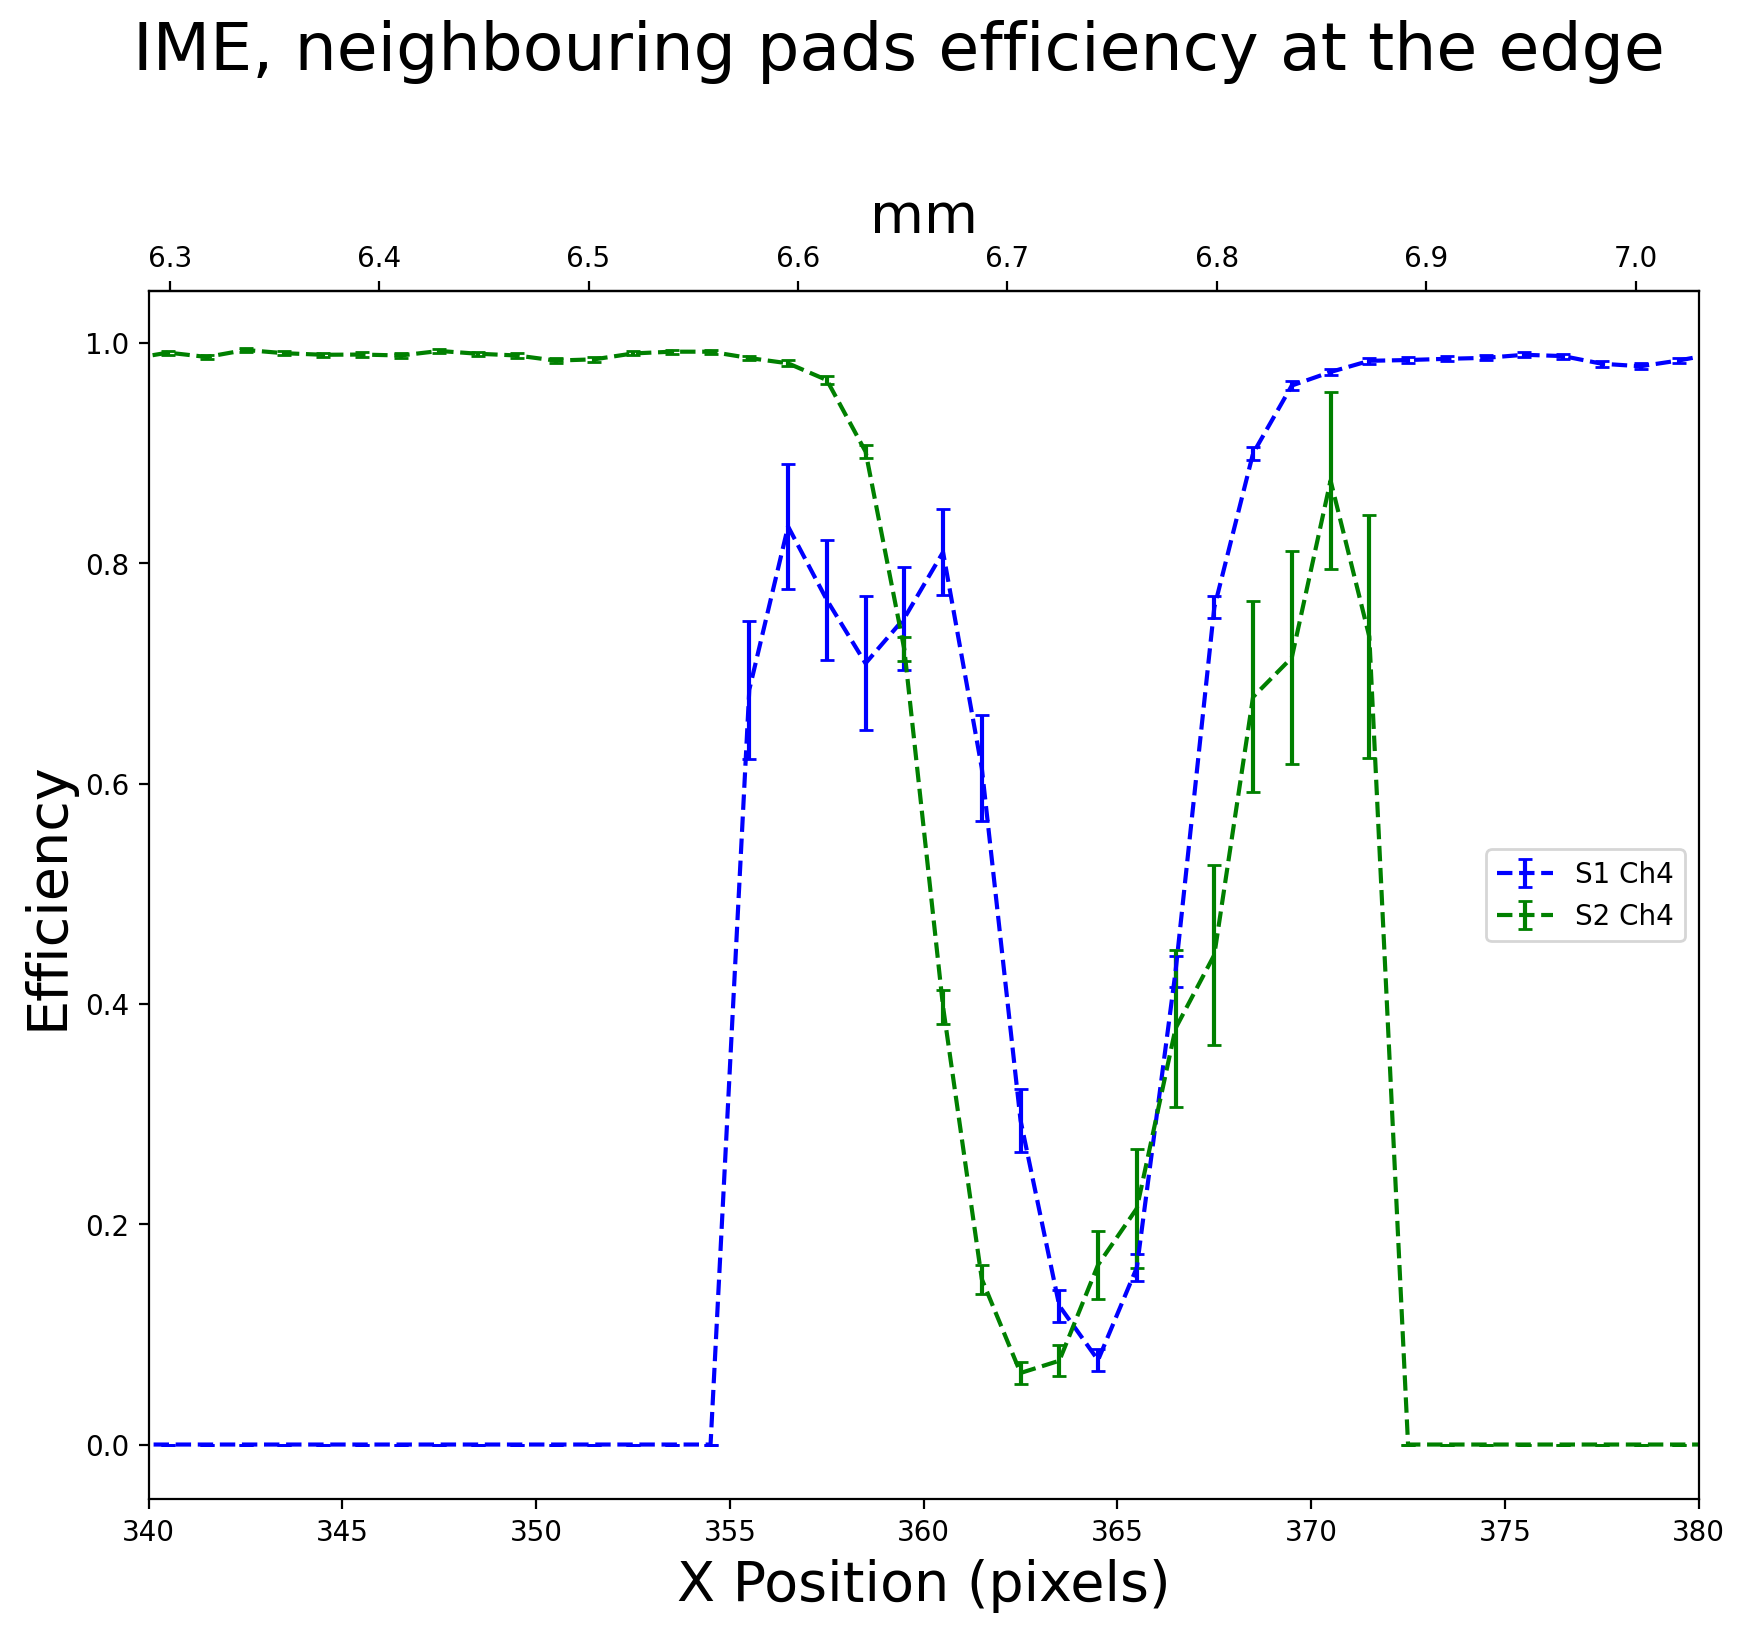

In [7]:
### plot of efficiency of the two channels next to each other,
### only the Y axis (where the pads are seen next to eachother)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,8), dpi=200)
# fig.tight_layout(w_pad=6, h_pad=10)

bins_find_min = 'rice'
extended_fraction=.2
XY = 'Y'
coord_idx = 1

dut = 3
S = 'S1'
df = load_batch(this_batch,S)

time_cut = time_mask(df, DUT_number=dut, sigmas=3)[0]
one_axis_cut, edges = geometry_mask(df, DUT_number=dut, bins=these_bins, bins_find_min=bins_find_min, only_select=XY, use='pulseheight')
bool_mask = np.logical_and(one_axis_cut, time_cut)
#     bool_mask = np.ones_like(geo_cut)  ### no cuts

events_above_threshold = df[f"charge_{dut}"].loc[bool_mask]/transimpedance > threshold_charge
above_threshold = np.logical_and(bool_mask, events_above_threshold)
total_events_in_bin, bins_edges = np.histogram(df[f"{XY}tr_{dut-1}"].loc[bool_mask], bins=these_bins[coord_idx])
events_above_threshold_in_bin, _  = np.histogram(df[f"{XY}tr_{dut-1}"].loc[above_threshold], bins=these_bins[coord_idx])
eff, err = efficiency_k_n(events_above_threshold_in_bin, total_events_in_bin)

bins_centers = (bins_edges[:-1]+bins_edges[1:])/2

axes.errorbar(bins_centers, eff, yerr=err, c=colormap[1], linestyle='--', label=f"{S} Ch{dut+1}", markersize=3, capsize=2.5)#, drawstyle='steps-mid')


dut = 3
S = 'S2'
df = load_batch(this_batch,S)

time_cut = time_mask(df, DUT_number=dut, sigmas=3)[0]
one_axis_cut, edges = geometry_mask(df, DUT_number=dut, bins=these_bins, bins_find_min=bins_find_min, only_select=XY, use='pulseheight')
bool_mask = np.logical_and(one_axis_cut, time_cut)

events_above_threshold = df[f"charge_{dut}"].loc[bool_mask]/transimpedance > threshold_charge
above_threshold = np.logical_and(bool_mask, events_above_threshold)
total_events_in_bin, bins_edges = np.histogram(df[f"{XY}tr_{dut-1}"].loc[bool_mask], bins=these_bins[coord_idx])
events_above_threshold_in_bin, _  = np.histogram(df[f"{XY}tr_{dut-1}"].loc[above_threshold], bins=these_bins[coord_idx])
eff, err = efficiency_k_n(events_above_threshold_in_bin, total_events_in_bin)

bins_centers = (bins_edges[:-1]+bins_edges[1:])/2

axes.errorbar(bins_centers, eff, yerr=err, c=colormap[2], linestyle='--', label=f"{S} Ch{dut+1}", markersize=3, capsize=2.5)#, drawstyle='steps-mid')

axes.set_xlim(340,380)
# axes.set_xlim(250,300)


axes.set_xlabel('X Position (pixels)', fontsize=20)
secx = axes.secondary_xaxis('top', functions=(lambda x: x*PIXEL_SIZE, lambda y: y*PIXEL_SIZE))
secx.set_xlabel('mm', fontsize=20)

axes.set_ylabel("Efficiency", fontsize=20)
axes.legend()

fig.suptitle("IME, neighbouring pads efficiency at the edge", fontsize=24, y=1.05)

# if SAVE:
fig.savefig(os.path.join(pres_path, f"IME, batch {this_batch}, edge efficiency studies.png"), bbox_inches="tight")


# Angled tracks
compare if angled tracks have more charge sharing the straight ones

## Load the batch
set general variables for the whole batch

In [8]:
SAVE = False

colormap = ['k','b','g','r','orange']
threshold_charge = 4 #fC
DUTs = [3]

# print("Batch: ", this_batch)
# print(S)
# df = load_batch(this_batch,S)

these_bins = bins5
time_bins = 5000
use_for_geometry_cut = 'pulseheight'


In [9]:

df = {}
df["203_0"] = load_batch(203,'S1') # dut=1 and dut=2
df["206_13"] = load_batch(206,'S1') # dut=1 and dut=2

# df["S1_6"] = load_batch(413,'S1')
# df["S2_6"] = load_batch(413,'S2')
# df["S1_13"] = load_batch(411,'S1')
# df["S2_13"] = load_batch(411,'S2')


## Now I pick the intervals manually
I want to pick the geometry cut of pad1 and apply it pad2


In [10]:
# other_pad = [-5e3,-4.6e3]

# fig, axes = plot(df["Ch2_0"], "Time_pulseHeight", dict_of_batches[206], 'S1', bins=time_bins, info=False, extra_info=False,
#                n_DUT=[1], savefig=False)

# axes[0].axvline(other_pad[0], color='orange')
# axes[0].axvline(other_pad[1], color='orange')

In [11]:
DUTs = [1,2]
geo_cuts, geo_infos = zip(*[geometry_mask(df["203_0"], DUT_number=dut, bins=these_bins, bins_find_min='rice', only_select='normal', use=use_for_geometry_cut)
                            if dut in DUTs else (None,None) for dut in [1,2,3]])
# time_cuts = time_mask(df["203_0"], DUT_number=dut, sigmas=3)[0]


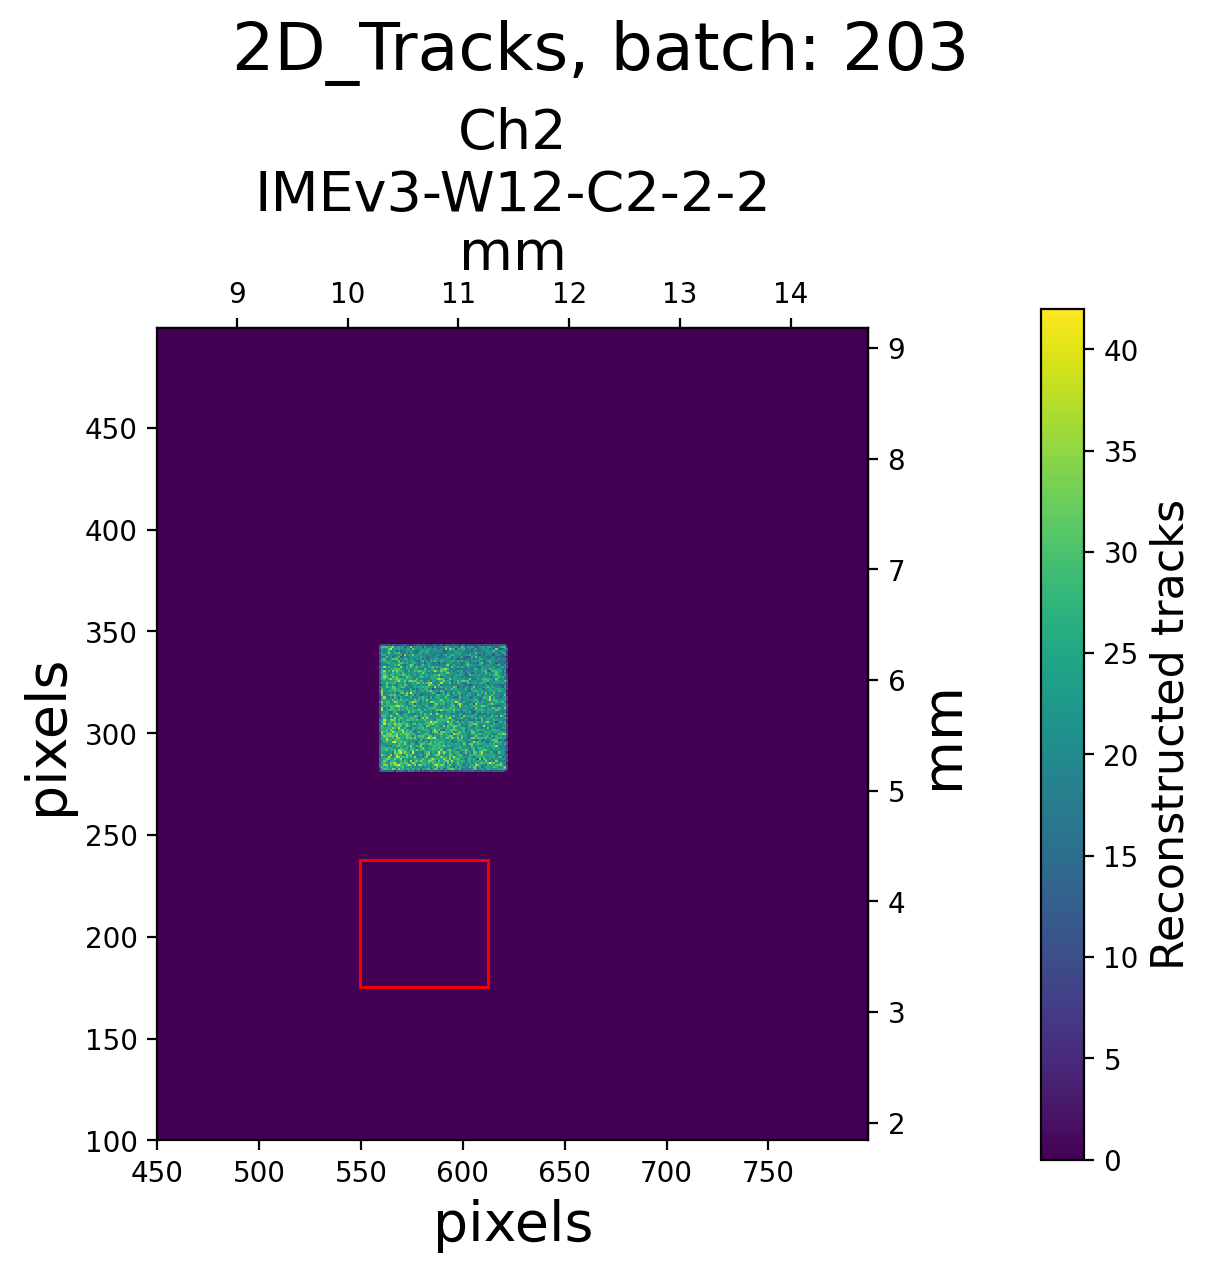

In [12]:
# second_peak = [np.logical_and((df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])> interesting_interval_2[0],
#                                (df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])< interesting_interval_2[1]) for dut in [1,2,3]]
dut = 1
other_dut = 2
fig, axes = plot(df["203_0"], "2D_Tracks", dict_of_batches[203], 'S1', bins=these_bins, n_DUT=[dut], mask=[geo_cuts[other_dut-1]]*3,
                    savefig=False)

axes[0].add_patch(rectangle_from_geometry_cut(**geo_infos[dut-1]))


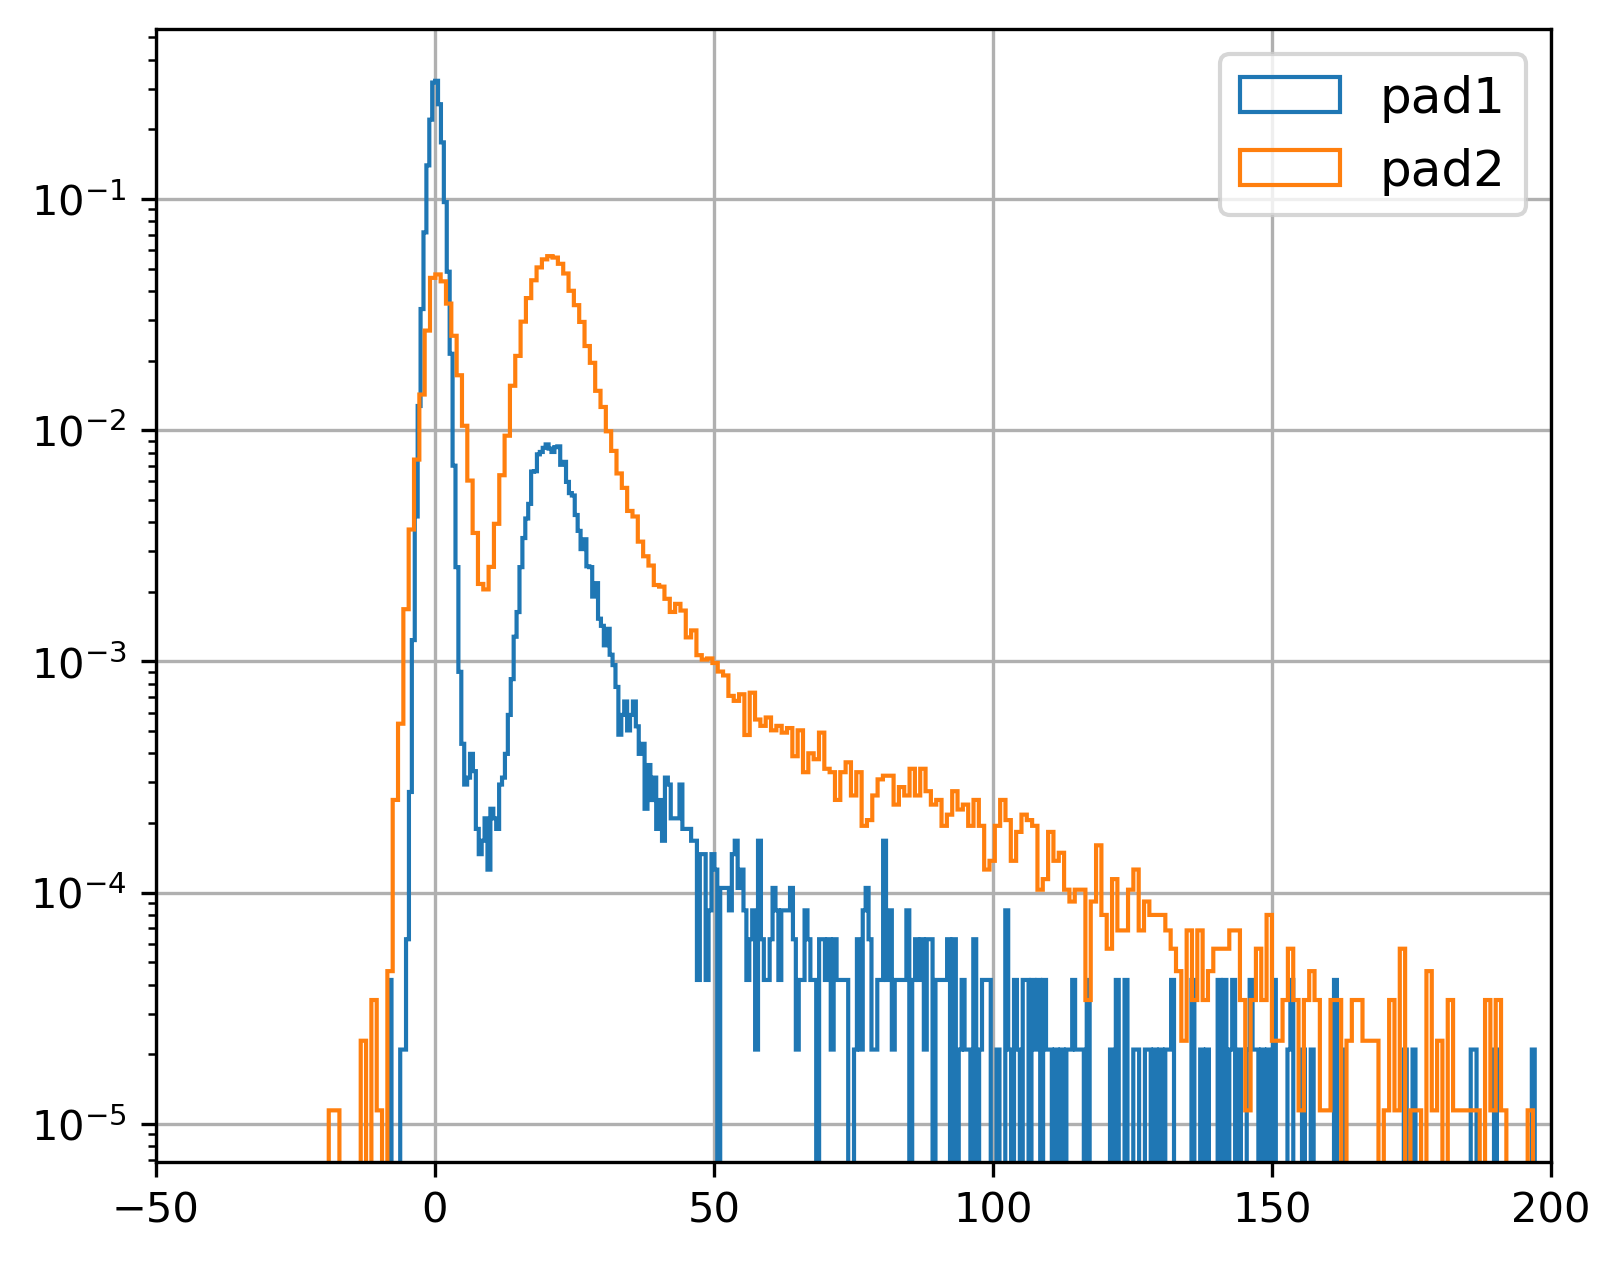

In [13]:
fig, ax = plt.subplots(figsize=(6,5), ncols=1, dpi=300)
plot_histogram(df["203_0"][f"charge_{dut}"].loc[geo_cuts[1]]/4700, bins=1000, fig_ax=(fig,ax), label='pad1', density=True)
plot_histogram(df["203_0"][f"charge_{other_dut}"].loc[geo_cuts[1]]/4700, bins=1000, fig_ax=(fig,ax), label='pad2', density=True)
ax.semilogy()
ax.set_xlim(-50,200)
ax.legend(fontsize=12)

In [14]:
DUTs = [1,2]
geo_cuts, geo_infos = zip(*[geometry_mask(df["206_13"], DUT_number=dut, bins=these_bins, bins_find_min='rice', only_select='normal', use=use_for_geometry_cut)
                            if dut in DUTs else (None,None) for dut in [1,2,3]])

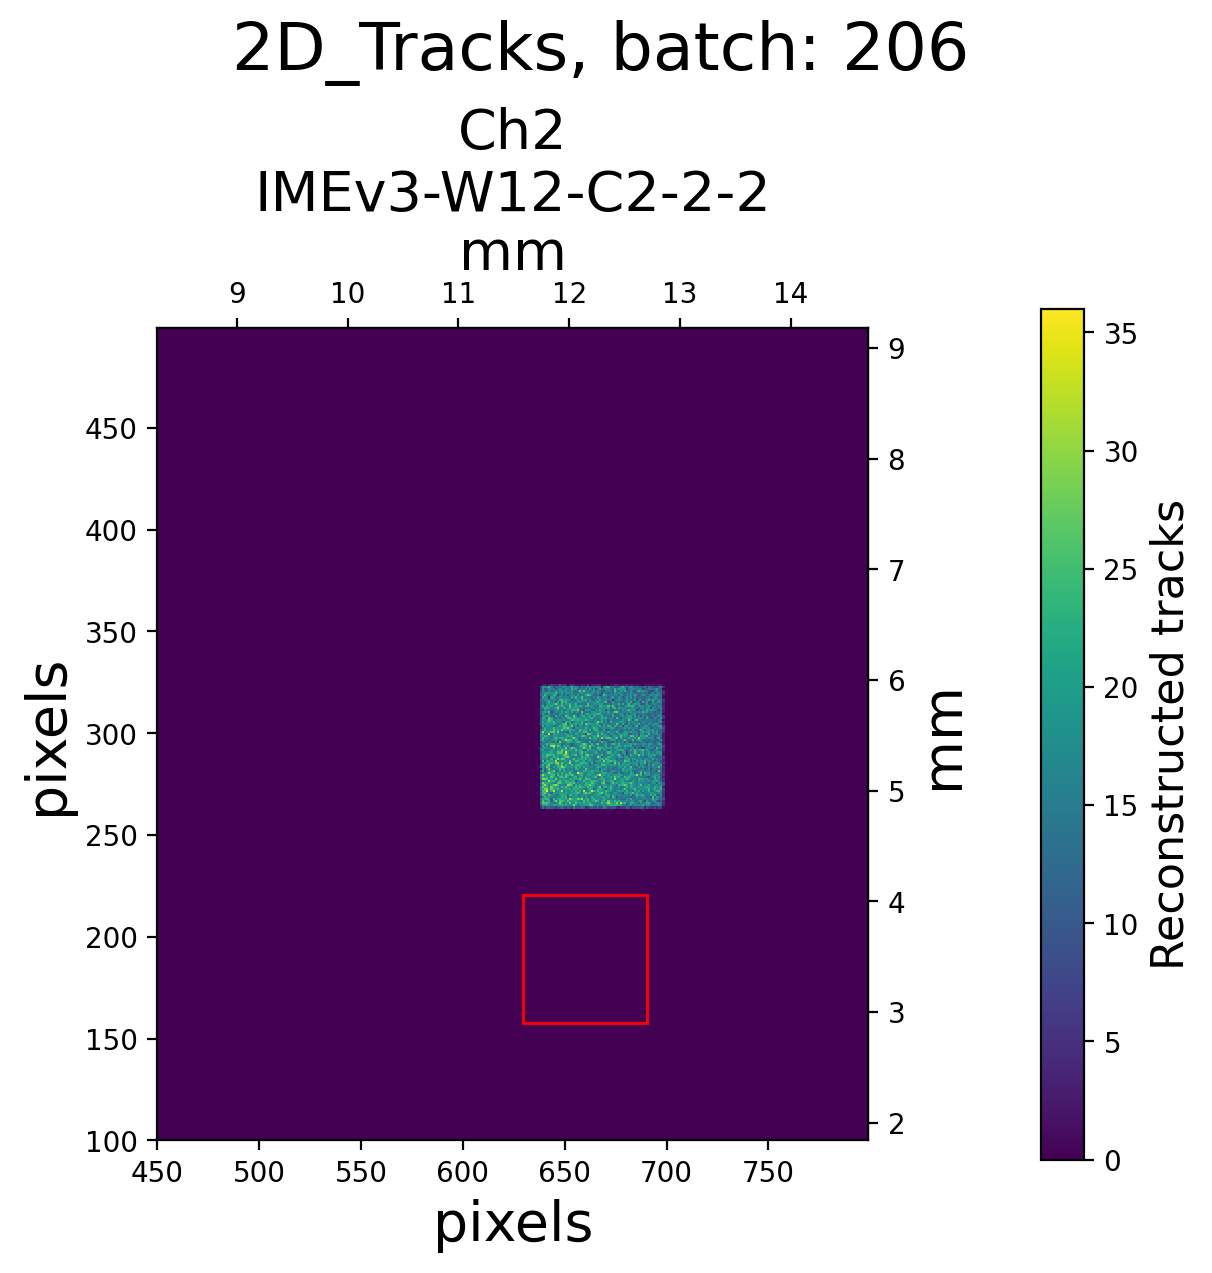

In [15]:

fig, axes = plot(df["206_13"], "2D_Tracks", dict_of_batches[206], 'S1', bins=these_bins, n_DUT=[dut], mask=[geo_cuts[other_dut-1]]*3,
                    savefig=False)

axes[0].add_patch(rectangle_from_geometry_cut(**geo_infos[dut-1]))

[]

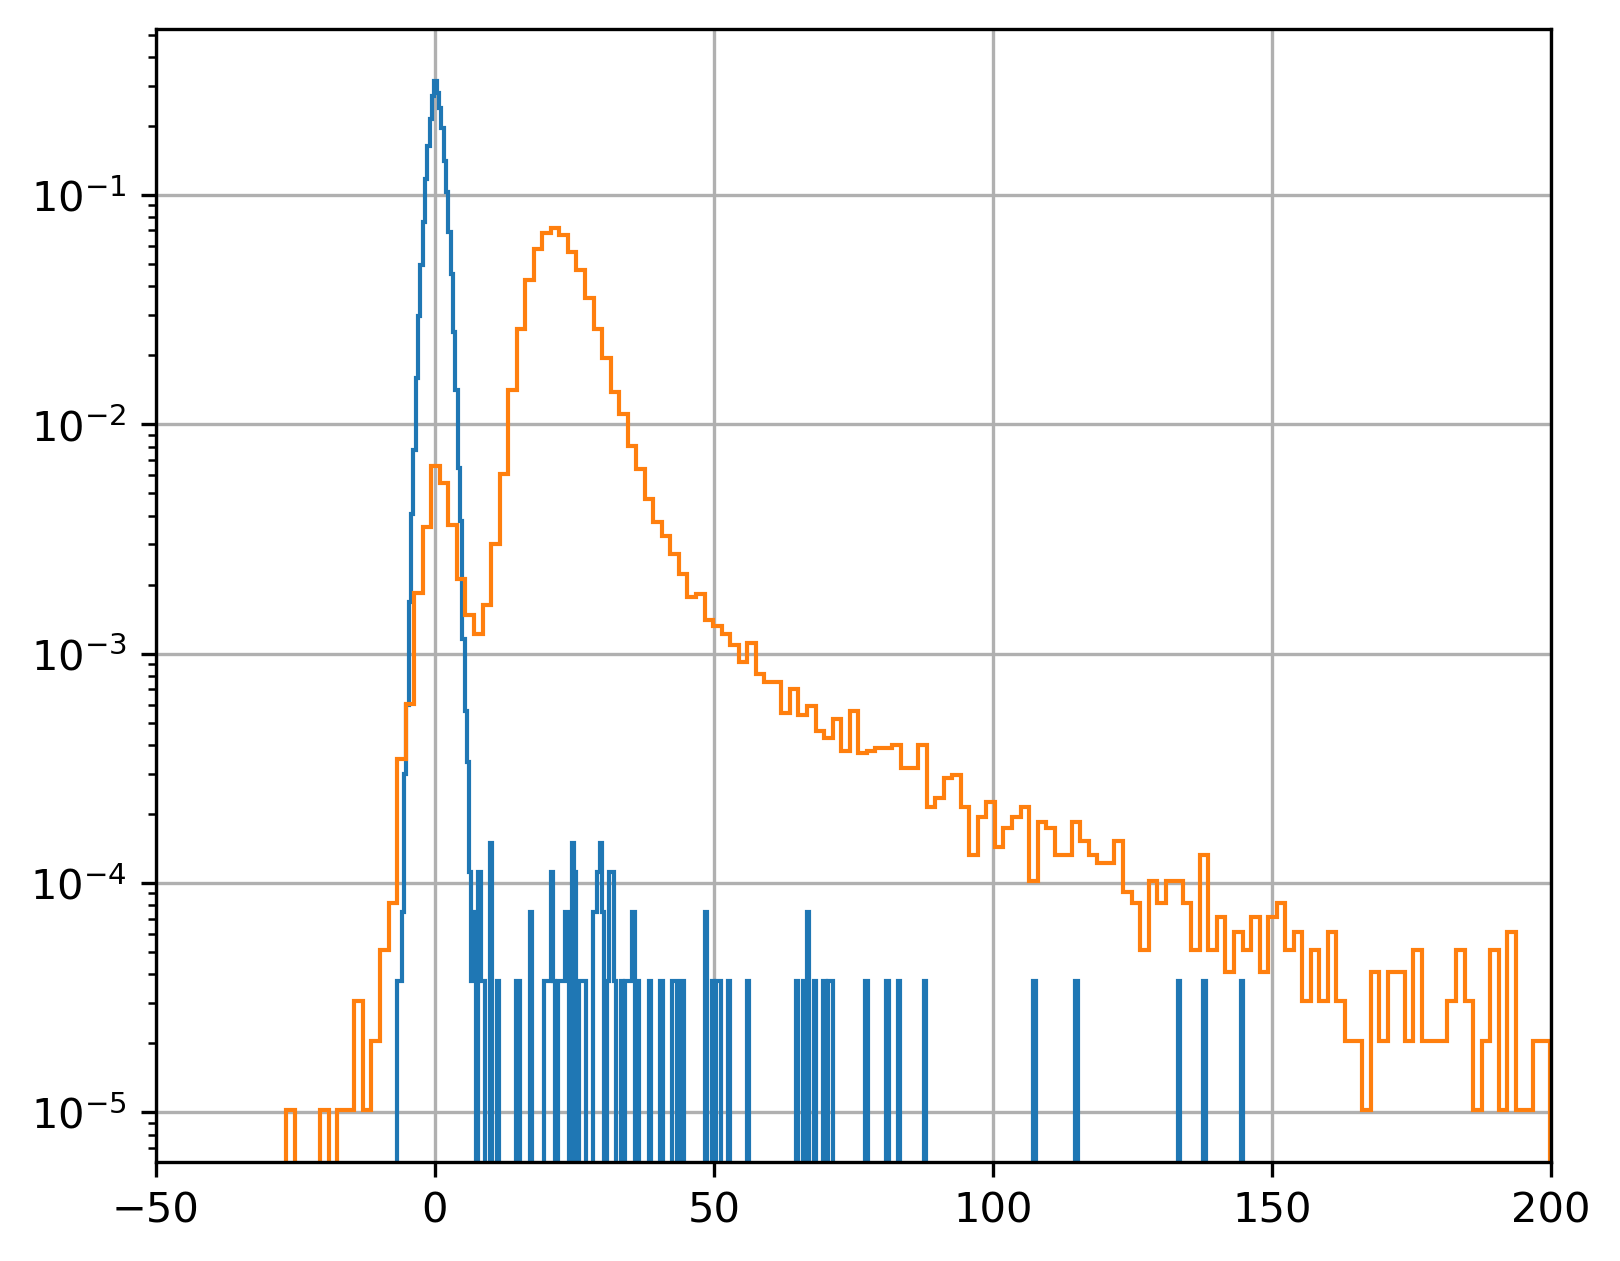

In [16]:
fig, ax = plt.subplots(figsize=(6,5), ncols=1, dpi=300)
plot_histogram(df["206_13"][f"charge_{1}"].loc[geo_cuts[1]]/4700, bins=500, fig_ax=(fig,ax), density=True)
plot_histogram(df["206_13"][f"charge_{2}"].loc[geo_cuts[1]]/4700, bins=500, fig_ax=(fig,ax), density=True)
ax.set_xlim(-50,200)
ax.semilogy()

In [17]:
dict_of_batches[206].runs

AttributeError: 'Batch' object has no attribute 'runs'

## USTC 0° - 6°

In [ ]:
these_bins = bins1
time_bins = 5000
use_for_geometry_cut = 'pulseheight'

df = {}
df["407_0"] = load_batch(407,'S1') # dut=1 and dut=2
df["413_6"] = load_batch(413,'S1') # dut=1 and dut=2


In [ ]:
DUTs = [1,2]
geo_cuts, geo_infos = zip(*[geometry_mask(df["407_0"], DUT_number=dut, bins=these_bins, bins_find_min='rice', only_select='normal', use=use_for_geometry_cut)
                            if dut in DUTs else (None,None) for dut in [1,2,3]])
# time_cuts = time_mask(df["203_0"], DUT_number=dut, sigmas=3)[0]


In [ ]:
fig, axes = plot(df["407_0"], "2D_Tracks", dict_of_batches[407], 'S1', bins=these_bins, n_DUT=[2], mask=[geo_cuts[0]]*3,
                    savefig=False)

axes[0].add_patch(rectangle_from_geometry_cut(**geo_infos[1]))


In [ ]:
fig, ax = plt.subplots(figsize=(6,5), ncols=1, dpi=300)
plot_histogram(df["407_0"][f"charge_{1}"].loc[geo_cuts[1]]/4700, bins=2000, fig_ax=(fig,ax), label='pad1', density=True)
plot_histogram(df["407_0"][f"charge_{2}"].loc[geo_cuts[1]]/4700, bins=2000, fig_ax=(fig,ax), label='pad2', density=True)
ax.semilogy()
ax.set_xlim(-50,200)
ax.legend(fontsize=12)

In [ ]:
DUTs = [1,2]
geo_cuts, geo_infos = zip(*[geometry_mask(df["413_6"], DUT_number=dut, bins=these_bins, bins_find_min='rice', only_select='normal', use=use_for_geometry_cut)
                            if dut in DUTs else (None,None) for dut in [1,2,3]])

In [ ]:
fig, axes = plot(df["413_6"], "2D_Tracks", dict_of_batches[413], 'S1', bins=these_bins, n_DUT=[1], mask=[geo_cuts[1]]*3,
                    savefig=False)

axes[0].add_patch(rectangle_from_geometry_cut(**geo_infos[0]))

In [ ]:
fig, ax = plt.subplots(figsize=(6,5), ncols=1, dpi=300)
plot_histogram(df["413_6"][f"charge_{1}"].loc[geo_cuts[1]]/4700, bins=2000, fig_ax=(fig,ax), density=True)
plot_histogram(df["413_6"][f"charge_{2}"].loc[geo_cuts[1]]/4700, bins=2000, fig_ax=(fig,ax), density=True)
ax.set_xlim(-50,200)

ax.semilogy()